<h1>
    <span style="color:darkgrey">
         ПРОЕКТ E-COMMERCE
    </span>
</h1>

----

<h2>
    <span style="color:darkgrey">
        Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы: 
    </span>
</h2>

----

1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре *2021* года *4,28* недели. И внутри метрики это нужно учесть.

5. Используя `pandas`, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким `retention` на 3й месяц. Описание подхода можно найти тут.

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя `python`, построй **RFM-сегментацию** пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: **R** - время от последней покупки пользователя до текущей даты, **F** - суммарное количество покупок у пользователя за всё время, **M** - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик `recency`, `frequency` и `monetary` для интерпретации этих кластеров. Пример такого описания: RFM-сегмент *132* (`recency=1, frequency=3, monetary=2`) имеет границы метрик recency от *130* до *500* дней, frequency от *2* до *5* заказов в неделю, monetary от *1780* до *3560* рублей в неделю. Описание подхода можно найти тут.

**Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться *покупкой*. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.**

Файлы:

- `olist_customers_datase.csv` — таблица с уникальными идентификаторами пользователей
  - `customer_id` — позаказный идентификатор пользователя
  - `customer_unique_id` —  уникальный идентификатор пользователя  (аналог номера паспорта)
  - `customer_zip_code_prefix` —  почтовый индекс пользователя
  - `customer_city` —  город доставки пользователя
  - `customer_state` —  штат доставки пользователя


- `olist_orders_dataset.csv` —  таблица заказов
  - `order_id` —  уникальный идентификатор заказа (номер чека)
  - `customer_id` —  позаказный идентификатор пользователя
  - `order_status` —  статус заказа
  - `order_purchase_timestamp` —  время создания заказа
  - `order_approved_at` —  время подтверждения оплаты заказа
  - `order_delivered_carrier_date` —  время передачи заказа в логистическую службу
  - `order_delivered_customer_date` —  время доставки заказа
  - `order_estimated_delivery_date` —  обещанная дата доставки


- `olist_order_items_dataset.csv` —  товарные позиции, входящие в заказы
  - `order_id` —  уникальный идентификатор заказа (номер чека)
  - `order_item_id` —  идентификатор товара внутри одного заказа
  - `product_id` —  ид товара (аналог штрихкода)
  - `seller_id` — ид производителя товара
  - `shipping_limit_date` —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
  - `price` —  цена за единицу товара
  - `freight_value` —  вес товара

— Пример структуры данных можно визуализировать по `order_id == 00143d0f86d6fbd9f9b38ab440ac16f5`

Уникальные статусы заказов в таблице `olist_orders_dataset`:
- `created` —  создан
- `approved` —  подтверждён
- `invoiced` —  выставлен счёт
- `processing` —  в процессе сборки заказа
- `shipped` —  отгружен со склада
- `delivered` —  доставлен пользователю
- `unavailable` —  недоступен
- `canceled` —  отменён

In [240]:
#импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import plotly.express as px
import numpy as np
from datetime import timedelta
import requests
from urllib.parse import urlencode
from operator import attrgetter

#выставим настройки графика
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [2]:
# использрвание api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key_orders = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw' 
public_key_customers = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
public_key_items = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg' 
    
# получение url 
final_url_orders = base_url + urlencode(dict(public_key=public_key_orders))
final_url_customers = base_url + urlencode(dict(public_key=public_key_customers))
final_url_items = base_url + urlencode(dict(public_key=public_key_items))

response_orders = requests.get(final_url_orders)
response_customers = requests.get(final_url_customers)
response_items = requests.get(final_url_items)
 
download_url_orders = response_orders.json()['href']
download_url_customers = response_customers.json()['href'] 
download_url_items = response_items.json()['href'] 

# загрузка файлов
download_response_orders = requests.get(download_url_orders)
download_response_customers = requests.get(download_url_customers)
download_response_items = requests.get(download_url_items)

---
Загрузим имеющиеся данные

---

In [3]:
df_customers = pd.read_csv(download_url_customers)
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [5]:
df_orders = pd.read_csv(download_url_orders, parse_dates=[3, 4, 5, 6, 7])
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [6]:
#посмотрим информарцию о датафрейме с заказами
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [7]:
df_order_items = pd.read_csv(download_url_items, parse_dates=[4])
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [8]:
#посмотрим информарцию о датафрейме с содержанием заказов
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


---
В датафрейме присутствуют нулевые значения веса. посмотрим количество таких заказов.

---

In [9]:
df_order_items.query('freight_value == 0')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
114,00404fa7a687c8c44ca69d42695aae73,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,2018-05-15 04:31:26,99.9,0.0
258,00a870c6c06346e85335524935c600c0,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-05-14 00:14:29,69.9,0.0
483,011c899816ea29773525bd3322dbb6aa,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,2018-05-07 05:30:45,99.9,0.0
508,012b3f6ab7776a8ab3443a4ad7bef2e6,1,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-05-09 21:30:50,53.9,0.0
509,012b3f6ab7776a8ab3443a4ad7bef2e6,2,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-05-09 21:30:50,53.9,0.0
...,...,...,...,...,...,...,...
111094,fc698f330ec7fb74859071cc6cb29772,1,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-04-25 02:31:57,53.9,0.0
111497,fd4907109f6bac23f07064af84bec02d,1,7a10781637204d8d10485c71a6108a2e,4869f7a5dfa277a7dca6462dcf3b52b2,2018-04-30 11:31:32,219.0,0.0
111649,fd95e4b85ebbb81853d4a6be3d61432b,1,53b36df67ebb7c41585e8d54d6772e08,4869f7a5dfa277a7dca6462dcf3b52b2,2018-05-04 11:10:31,106.9,0.0
112182,fee19a0dc7358b6962a611cecf6a37b4,1,f1c7f353075ce59d8a6f3cf58f419c9c,37be5a7c751166fbc5f8ccba4119e043,2017-09-07 22:06:31,195.0,0.0


In [10]:
df_order_items.query('freight_value == 0').describe()

,order_item_id,price,freight_value
count,383.000000,383.000000,383.0
mean,1.146214,98.601488,0.0
std,0.462782,50.004247,0.0
min,1.000000,53.900000,0.0
25%,1.000000,69.900000,0.0
50%,1.000000,99.900000,0.0
75%,1.000000,106.900000,0.0
max,5.000000,712.900000,0.0


---
Возможно такие заказы имеют слишком маленький вес, поэтому не отображатся в колонке с весом. Количество таких значений не велико, поэтому оставим данные строки для анализа.

---

---
Рассмотрим более детально пропущеннее значения в датафрейме заказов df_orders

---

In [11]:
df_orders_eda = df_orders
df_orders_eda.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [12]:
df_orders_eda.query('order_approved_at == "NaN"').order_status.unique()

array(['canceled', 'delivered', 'created'], dtype=object)

---
Пропуски имеют статусы заказов **'canceled'** - заказ отменен, **'delivered'** - доставлен пользователю, **'created'** - создан. Заказы со статусами **'canceled'** и **'create'** оставляем, потому что в первом случае заказ отмене и у него не может быть даты подтверждения, а во втором заказ только создан, дата подтверждения заказа поступает только после оплаты. Рассмотрим более детально заказы со статусом **'delivered'**

---

In [13]:
df_orders_eda.query('order_approved_at == "NaN" and order_status == "delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


---
Мы наблюдаем что доставленных заказов с отсутствующим значением даты подтверждения(**order_approved_at**) оплаты мало и при этом у всех подобных заказов есть дата(**order_delivered_carrier_date**) доставки и дата передачи в логистическую службу(**order_delivered_customer_date**). Скорее всего в программе произошел сбой и как следствие даты подтверждения заказов оказались пропущены.

---

---
Посмотрим на пропущенные значения в столбце дата передачи в логистическую службу(**order_delivered_carrier_date**)

---

In [14]:
df_orders_eda.query('order_delivered_carrier_date == "NaN"').order_status.unique()

array(['invoiced', 'processing', 'unavailable', 'canceled', 'created',
       'approved', 'delivered'], dtype=object)

---
Заказы со статусами **'invoiced', 'processing', 'unavailable', 'canceled', 'created', 'approved'** не должны иметь дату передачи в службу доставки(**order_delivered_carrier_date**), потому что эти статусы формируются до передачи в службу логистики. Эти данные мы оставляем.

---
Рассмотрим более детально заказы у которых отсутствует дата передачи в логистическую службу, но есть статус доставлено.

---

In [15]:
df_orders_eda.query('order_delivered_carrier_date == "NaN" and order_status == "delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
73222,2aa91108853cecb43c84a5dc5b277475,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,NaT,2017-11-20 19:44:47,2017-11-14
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23


---
Заказ с индексом **73222** не будем удалять, потому что у этого заказа есть дата доставки(**order_delivered_customer_date**) и дата подтверждение оплаты(**order_approved_at**).

Строка с индексом **92643** будет удалена вместе с остальными заказами ниже

---

---
Теперь рассмотрим заказы с пропущенными значениями даты доставки


---

In [16]:
df_orders_eda.query('order_delivered_customer_date == "NaN"').order_status.unique()

array(['invoiced', 'shipped', 'processing', 'unavailable', 'canceled',
       'delivered', 'created', 'approved'], dtype=object)

---
В данном датасете для всех статусов кроме статуса **'delivered'**, наличие пропущенных значений логично, поэтому удалять будем только те строки в которых есть статус заказа доставлен и отсутствует дата доставки.

---

In [17]:
df_orders_eda.query('order_delivered_customer_date == "NaN" and order_status == "delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


---
Рассмотрим подробнее заказы со статусом недоступен(**'unavailable'**) и попробуем выяснить что означает этот статус

---

In [18]:
df_orders_eda.query('order_status == "unavailable"').isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     609
order_delivered_customer_date    609
order_estimated_delivery_date      0
dtype: int64

---
У заказов с этим статусом отсутсвуют даты передачи в логистическую службу(**order_delivered_carrier_date**) и даты доставки(**order_delivered_customer_date**). То есть, эти заказы были оплачены, но не переданы в доставку. Можем предположить, что товар присутствующий в этих заказах отсутствовал на складе в следствии чего весь заказ получил статус недоступен(**'unavailable'**)

---

---
Теперь отберем индексы строк датафрейма которые подлежат удалению

---

In [19]:
index_drop = df_orders_eda.query('order_delivered_customer_date == "NaN" and order_status == "delivered"').reset_index()
index_drop = index_drop['index']
index_drop

0     3002
1    20618
2    43834
3    79263
4    82868
5    92643
6    97647
7    98038
Name: index, dtype: int64

---
Удалим из исходного датафрейма строки с полученными индексами

---

In [20]:
df_orders = df_orders.drop(index=index_drop).reset_index(drop=True)

In [21]:
#посмотрим на количество пропущенных значений в получившемся датафрейме
df_orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1782
order_delivered_customer_date    2957
order_estimated_delivery_date       0
dtype: int64

---
## 1. Расчет количества пользователей совершивших покупку только один раз.

---

---
Для ответа на данный вопрос необходимо ввести критерии **покупки**. Покупку можно считать состоявшейся если она отвечает двум критериям:

1. У нее есть дата подтверждения оплаты.
2. Статус заказа имеет значение доставлен(**delivered**). Таким образом мы отсеиваем покупателей, которые потенциально могут не получить товар по разным причинам(отказались от товара, нет на складе и пр.)


In [22]:
#чтобы ответить на этот вопрос необходимо соединить таблицы с заказами и таблицы с идентификаторами пользователей по колонке
#позаказного id(customer_id)
result = pd.merge(df_orders, df_customers, how='left', on='customer_id')
result.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


---
Теперь отфильтруем данные: 
1. Оставим только строки у которых статус заказа соответсвует **'delivered'** и отсутствует пропуск в графе подтверждение оплаты (**"order_approved_at"**)
2. Сгруппируем заказ по уникальному id клиента(**customer_unique_id**)
3. Посчитаем количество заказов совершенного каждым покупателем
4. Оставим только тех клиентов, которые совершили 1 покупку
5. Подсчитаем их количество

---

In [23]:
result.query('order_approved_at != "NaN" and order_status == "delivered"')\
        .groupby('customer_unique_id', as_index=False)\
        .agg({'order_id': 'count'})\
        .rename(columns={'order_id': 'quant_orders'})\
        .query('quant_orders == 1')\
        .quant_orders.sum()

90537

> **Вывод:**\
Количество пользователей совершивших покупку один раз составляет - **90537**

---
## 2. Оценка количества недоставленных товаров в среднем в месяц.

---

---
Для правильного расчета необходимо ввести понятие недоставленного заказа. Недоставленным заказом будем считать тот, в который:

1. Имеет статус недоступен(**unavailable**)
2. Имеет статус отменен(**canceled**)
3. Превышено ожидаемое время доставки(дата фактической доставки превышает дату запланированной доставки)


---

In [160]:
df_not_delivered = df_orders.query('order_delivered_customer_date > order_estimated_delivery_date or\
                                    order_status == "canceled" or\
                                    order_status == "unavailable"')\
                                    [['order_id', 'order_status', 'order_estimated_delivery_date']]
df_not_delivered.head()

,order_id,order_status,order_estimated_delivery_date
20,203096f03d82e0dffbc41ebc2e2bcfb7,delivered,2017-09-28
25,fbf9ac61453ac646ce8ad9783d7d0af6,delivered,2018-03-12
35,8563039e855156e48fccee4d611a3196,delivered,2018-03-20
41,6ea2f835b4556291ffdc53fa0b3b95e8,delivered,2017-12-21
57,66e4624ae69e7dc89bd50222b59f581f,delivered,2018-04-02


---
Определим месяц недоставленных заказов по планируемой дате доставки **order_estimated_delivery_date**

---

In [161]:
#приведем дату планируемой доставки к виду год-месяц
df_not_delivered.order_estimated_delivery_date = df_not_delivered.order_estimated_delivery_date.dt.to_period('M').astype(str)

df_not_delivered.order_estimated_delivery_date = pd.to_datetime(df_not_delivered.order_estimated_delivery_date)

In [162]:
#для наглядности поменяем заказы со статусом delivered к статусу latecomers
df_not_delivered.order_status = df_not_delivered.order_status.apply(lambda x: 'latecomers' if x == 'delivered' else x)

<AxesSubplot:xlabel='order_estimated_delivery_date', ylabel='Count'>

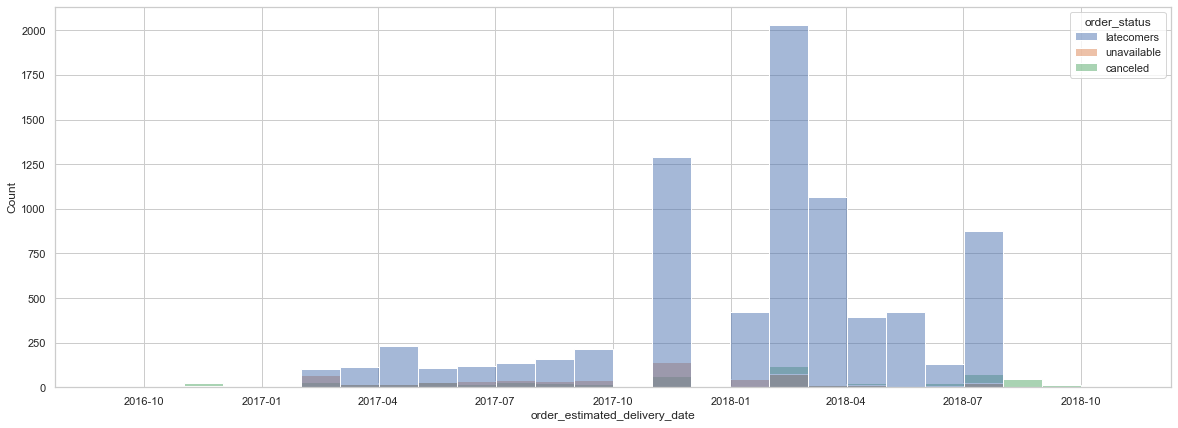

In [163]:
#Посмотрим получившиеся распределение на гистограмме, сделаем разбивку по месяцам
sns.histplot(data=df_not_delivered, x = 'order_estimated_delivery_date', hue='order_status', bins=26)

---
Мы видим, что большая часть недоставленных заказов не пришла в планируемую дату доставки. Теперь посчитаем это количество и высчитаем средние значения.

---

In [165]:
#Сгруппируем данные по колонке order_estimated_delivery_date и order_status подсчитав количество заказов
df_not_delivered_filter = df_not_delivered.groupby(['order_estimated_delivery_date', 'order_status'], as_index=False)\
                                            .agg({'order_id': 'count'})\
                                            .rename(columns={'order_estimated_delivery_date': 'month_not_delivered',\
                                                             'order_id': 'quantyti_orders'})
df_not_delivered_filter.head()

,month_not_delivered,order_status,quantyti_orders
0,2016-09-01,canceled,1
1,2016-10-01,canceled,3
2,2016-10-01,latecomers,1
3,2016-11-01,canceled,14
4,2016-11-01,latecomers,2


In [166]:
df_not_delivered_filter.groupby('order_status', as_index=True).agg({'quantyti_orders': 'mean'}).round(0)

,quantyti_orders
order_status,
canceled,24.0
latecomers,356.0
unavailable,29.0


>**Вывод**:
>1. Заказ не доставлен вовремя: 356/месяц
>2. Заказ был отменен: 24/месяц
>3. Заказ не смогли сформировать: 29/месяц

---
## 3. Определение в какой день недели товар чаще всего покупается.

---

In [142]:
#соеденим датафрейм заказов с датафреймом состава заказов и запишем в новой датафрейм
#при этом оставим только те столбцы которые нам нужны

df_product_day = pd.merge(df_order_items, df_orders, how='left', on='order_id')\
                    [['product_id', 'order_purchase_timestamp', 'order_status']]
df_product_day.head()

,product_id,order_purchase_timestamp,order_status
0,4244733e06e7ecb4970a6e2683c13e61,2017-09-13 08:59:02,delivered
1,e5f2d52b802189ee658865ca93d83a8f,2017-04-26 10:53:06,delivered
2,c777355d18b72b67abbeef9df44fd0fd,2018-01-14 14:33:31,delivered
3,7634da152a4610f1595efa32f14722fc,2018-08-08 10:00:35,delivered
4,ac6c3623068f30de03045865e4e10089,2017-02-04 13:57:51,delivered


---
Для расчета примем, что дата покупки товара, это дата создания заказа в котором есть этот товар(**order_purchase_timestamp**)

---

In [143]:
#теперь переведем дату покупку в день недели и запишем эти данные в отделньую колонку
df_product_day['day_of_week'] = df_product_day['order_purchase_timestamp'].dt.strftime('%A')
df_product_day.head()

,product_id,order_purchase_timestamp,order_status,day_of_week
0,4244733e06e7ecb4970a6e2683c13e61,2017-09-13 08:59:02,delivered,Wednesday
1,e5f2d52b802189ee658865ca93d83a8f,2017-04-26 10:53:06,delivered,Wednesday
2,c777355d18b72b67abbeef9df44fd0fd,2018-01-14 14:33:31,delivered,Sunday
3,7634da152a4610f1595efa32f14722fc,2018-08-08 10:00:35,delivered,Wednesday
4,ac6c3623068f30de03045865e4e10089,2017-02-04 13:57:51,delivered,Saturday


In [152]:
#сгруппируем данные по продукту(product_id) и дню недели(day_of_week) и сделаем сводную таблицу
df_total_product_day = df_product_day.groupby(['product_id', 'day_of_week'], as_index=False)\
                                    .agg({'order_status': 'count'})\
                                    .sort_values('order_status', ascending = False)\
                                    .rename(columns={'order_status': 'quant'})
df_total_product_day.head()

,product_id,day_of_week,quant
15900,422879e10f46682990de24d770e7f83d,Wednesday,93
36511,99a4788cb24856965c36a24e339b6058,Monday,92
41042,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
41038,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,87
41043,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85


---
Мы посчитали все уникальные комбинации **"день недели-количество покупок"**, для каждого конкретного товара. Теперь чтобы избежать потерь строк в которых разные товары имеют одинаковое количество продаж в разные дни, создадим отдельный датафрейм где для каждого товара посчитаем максимальное количество покупок.

---

In [148]:
df_product_day_max = df_total_product_day.groupby('product_id', as_index = False)\
                                         .agg({'quant': 'max'})\
                                         .sort_values(by='quant', ascending=False)
df_product_day_max.head()

,product_id,quant
8612,422879e10f46682990de24d770e7f83d,93
19741,99a4788cb24856965c36a24e339b6058,92
22110,aca2eb7d00ea1a7b8ebd4e68314663af,89
10866,53b36df67ebb7c41585e8d54d6772e08,76
7363,389d119b48cf3043d311335e499d9c6b,67


In [154]:
#Соеденим получившиеся датафреймы
df_total_max_product_day = df_total_product_day.merge(df_product_day_max, on = 'product_id')

In [155]:
df_total_max_product_day.head()

,product_id,day_of_week,quant_x,quant_y
0,422879e10f46682990de24d770e7f83d,Wednesday,93,93
1,422879e10f46682990de24d770e7f83d,Thursday,79,93
2,422879e10f46682990de24d770e7f83d,Friday,77,93
3,422879e10f46682990de24d770e7f83d,Tuesday,67,93
4,422879e10f46682990de24d770e7f83d,Monday,64,93


In [158]:
#вывод итогового датафрейма с информацией о дне в который конкретный товар приобретился чаще всего
df_total_max_product_day[df_total_max_product_day.quant_x >=  df_total_max_product_day.quant_y]
df_total_max_product_day.head()

,product_id,day_of_week,quant_x,quant_y
0,422879e10f46682990de24d770e7f83d,Wednesday,93,93
1,422879e10f46682990de24d770e7f83d,Thursday,79,93
2,422879e10f46682990de24d770e7f83d,Friday,77,93
3,422879e10f46682990de24d770e7f83d,Tuesday,67,93
4,422879e10f46682990de24d770e7f83d,Monday,64,93


----
## 4. Расчет среднего количества покупок каждого клиента по месяцам. 


----

---
Как и в третьем задании данного проекта будем считать покупкой дату создания заказа(**order_purchase_timestamp**)

---

In [172]:
#чтобы посчитать количество покупок в неделю для каждого пользователя. Сначала соеденим таблицы в одну
#и выберем нужные столбцы
df_customers_week = pd.merge(pd.merge(df_order_items, df_orders, how='left', on='order_id')
                             , df_customers, how='left', on='customer_id')\
                            [['order_id', 'customer_unique_id', 'order_purchase_timestamp', 'product_id']]

df_customers_week.head()

,order_id,customer_unique_id,order_purchase_timestamp,product_id
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,4244733e06e7ecb4970a6e2683c13e61
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 10:53:06,e5f2d52b802189ee658865ca93d83a8f
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:33:31,c777355d18b72b67abbeef9df44fd0fd
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:00:35,7634da152a4610f1595efa32f14722fc
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04 13:57:51,ac6c3623068f30de03045865e4e10089


In [173]:
#создадим колонку состоящую из месяца и года покупки
df_customers_week['mount_purchase'] = df_customers_week['order_purchase_timestamp'].dt.strftime('%Y-%m')

In [174]:
#создадим колонку с указанием недель в каждом месяце
df_customers_week['weeks_in_month'] = round(df_customers_week['order_purchase_timestamp'].dt.days_in_month/7, 2)

In [175]:
#выведим на экран
df_customers_week.head()

,order_id,customer_unique_id,order_purchase_timestamp,product_id,mount_purchase,weeks_in_month
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,4244733e06e7ecb4970a6e2683c13e61,2017-09,4.29
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 10:53:06,e5f2d52b802189ee658865ca93d83a8f,2017-04,4.29
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:33:31,c777355d18b72b67abbeef9df44fd0fd,2018-01,4.43
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:00:35,7634da152a4610f1595efa32f14722fc,2018-08,4.43
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04 13:57:51,ac6c3623068f30de03045865e4e10089,2017-02,4.00


In [176]:
# сгруппируем количество покупок пользователей по месяцам и посчитаем количество покупок в каждом
df_customers_week = df_customers_week.groupby(['customer_unique_id', 'mount_purchase', 'weeks_in_month'], as_index=False)\
                                    .agg({'product_id': 'count'})\
                                    .sort_values('customer_unique_id')\
                                    .rename(columns={'product_id': 'Quant_purchase_in_month'})
df_customers_week.head()

,customer_unique_id,mount_purchase,weeks_in_month,Quant_purchase_in_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,4.43,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,4.43,1
2,0000f46a3911fa3c0805444483337064,2017-03,4.43,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,4.43,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,4.29,1


In [177]:
#добавим колонку со подсчестом среднего количества покупок в неделю, для каждого пользователя по месяцам.
df_customers_week['mean_purchase_in_week'] = round(df_customers_week.Quant_purchase_in_month / df_customers_week.weeks_in_month, 2)

In [178]:
#пересохраним датафрейм оставив только интересующие нас колонки и отсортируем его по id заказчика и месяцу покупки
df_customers_week = df_customers_week[['customer_unique_id', 'mount_purchase', 'mean_purchase_in_week']]
df_customers_week.sort_values(['customer_unique_id', 'mount_purchase'],ascending=False).head()

,customer_unique_id,mount_purchase,mean_purchase_in_week
97310,ffffd2657e2aad2907e67c3e9daecbeb,2017-05,0.23
97309,ffff5962728ec6157033ef9805bacc48,2018-05,0.23
97308,ffff371b4d645b6ecea244b27531430a,2017-02,0.25
97307,fffea47cd6d3cc0a88bd621562a9d061,2017-12,0.23
97306,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,0.47


> **Вывод:**\
> Мы получили таблицу с отображением среднего количества покупок в месяц по неделям.

---
## 5. Когортный анализ. Оценка метрики retention 3го месяца.

---

> Определение параметров перед проведением когортного анализа:
>
>1.  **Признак формирования когорты** — покупка;
>2.  **Размер когорты** — месяц;
>3.  **Отчетный период** — с января по декабрь 2017;
>4.  **Анализируемый ключевой показатель:** retention.
>
>**Retention** - это удержание пользователей, т.е. нужно найти когорту с самым высоким процентом повторных покупок на третий месяц 

In [180]:
df_orders.order_approved_at.min()

Timestamp('2016-09-15 12:16:38')

In [181]:
df_orders.order_approved_at.max()

Timestamp('2018-09-03 17:40:06')

---
В таблице присутствуют данные о заказах с сентября 2016го года по октябрь 2018, по условию задания необходимо анализировать заказы с января по декабрь. Делаем вывод, что необходимо проанализировать заказы за 17й год

---

In [304]:
#Сеоденим таблицы с данными по заказам и данными о покупателях, выберем нужные строки
df_total = pd.merge(df_orders, df_customers[['customer_id', 'customer_unique_id']], how='left', on='customer_id')\
                [['order_id', 'customer_unique_id', 'order_purchase_timestamp']]

In [305]:
df_total.head()

,order_id,customer_unique_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39


In [306]:
#вычислим дату первой покупки для каждого клиента. Датой покупки считаем дату подтверждения платежа(order_approved_at)
df_first_purchase = df_total.groupby('customer_unique_id', as_index=False)\
                            .agg({'order_purchase_timestamp':'min'})\
                            .rename(columns={'order_purchase_timestamp': 'date_first_purchase'})
df_first_purchase.head()

,customer_unique_id,date_first_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


In [308]:
#Смерджим данные в одну таблицу, чтобы каждый пользователь имел колонку с датой первой покупки
df_cohort = pd.merge(df_total, df_first_purchase, how='left', on='customer_unique_id')

In [307]:
df_cohort.head()

,order_id,customer_unique_id,order_purchase_timestamp,date_first_purchase
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02,2018-02


In [309]:
#приведем колонку даты первой покупки к формату год-месяц
df_cohort['date_first_purchase'] = df_cohort['date_first_purchase'].dt.to_period('M')
#приведем колонку даты последующих покупок покупки к формату год-месяц
df_cohort['order_purchase_timestamp'] = df_cohort['order_purchase_timestamp'].dt.to_period('M')

In [310]:
df_cohort.head()

,order_id,customer_unique_id,order_purchase_timestamp,date_first_purchase
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02,2018-02


In [323]:
#группируем данные по когортам и месяцам повторных покупок
df_cohort_pivot = df_cohort.groupby(['date_first_purchase','order_purchase_timestamp'])\
                            .agg({'customer_unique_id': 'nunique'})\
                            .rename(columns={'customer_unique_id': 'total_purchase'})\
                            .reset_index()
df_cohort_pivot.head()

,date_first_purchase,order_purchase_timestamp,total_purchase
0,2016-09,2016-09,4
1,2016-10,2016-10,321
2,2016-10,2017-04,1
3,2016-10,2017-07,1
4,2016-10,2017-09,1


In [324]:
#отфильтруем данные по интересующему нас периоду
df_cohort_pivot = df_cohort_pivot[(df_cohort_pivot['date_first_purchase'] >= '2017-01') & (df_cohort_pivot['date_first_purchase'] <= '2017-12')]
df_cohort_pivot.head()

,date_first_purchase,order_purchase_timestamp,total_purchase
12,2017-01,2017-01,764
13,2017-01,2017-02,3
14,2017-01,2017-03,2
15,2017-01,2017-04,1
16,2017-01,2017-05,3


In [325]:
#Создадим колонку с расчетом разницы месяцев в когорте
df_cohort_pivot['month_diff'] = (df_cohort_pivot.order_purchase_timestamp - df_cohort_pivot.date_first_purchase)\
                                    .apply(lambda x: int(x.n))
df_cohort_pivot.head()

,date_first_purchase,order_purchase_timestamp,total_purchase,month_diff
12,2017-01,2017-01,764,0
13,2017-01,2017-02,3,1
14,2017-01,2017-03,2,2
15,2017-01,2017-04,1,3
16,2017-01,2017-05,3,4


In [326]:
#развернем получившийся датафрейм для наглядности
df_retention = df_cohort_pivot.pivot(index='date_first_purchase', columns = 'month_diff', values = 'total_purchase')
df_retention

month_diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
date_first_purchase,,,,,,,,,,,,,,,,,,,
2017-01,764.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,3.0,1.0,6.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0,NaN
2017-03,2636.0,13.0,10.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,4.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN
2017-04,2352.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,5.0,NaN,NaN
2017-05,3595.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,9.0,11.0,9.0,12.0,9.0,1.0,7.0,9.0,NaN,NaN,NaN
2017-06,3139.0,15.0,11.0,13.0,8.0,12.0,12.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN
2017-07,3894.0,20.0,14.0,10.0,11.0,8.0,12.0,4.0,7.0,10.0,9.0,12.0,5.0,10.0,NaN,NaN,NaN,NaN,NaN
2017-08,4184.0,29.0,14.0,11.0,15.0,22.0,12.0,11.0,6.0,6.0,10.0,8.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4130.0,28.0,22.0,12.0,19.0,9.0,9.0,10.0,12.0,7.0,11.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [327]:
#рассчитаем отношение повторных покупок в последующие месяцы к первой покупке
df_retention_final = df_retention.div(df_retention.iloc[:, 0], axis=0)
df_retention_final

month_diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
date_first_purchase,,,,,,,,,,,,,,,,,,,
2017-01,1.0,0.003927,0.002618,0.001309,0.003927,0.001309,0.005236,0.001309,0.001309,NaN,0.003927,0.001309,0.007853,0.003927,0.001309,0.001309,0.002618,0.003927,0.001309
2017-02,1.0,0.002283,0.002854,0.001142,0.003995,0.001142,0.002283,0.001712,0.001712,0.002283,0.001142,0.002854,0.001712,0.001712,0.001142,0.000571,0.000571,0.002283,NaN
2017-03,1.0,0.004932,0.003794,0.003794,0.003414,0.001517,0.001517,0.003035,0.003414,0.000759,0.003794,0.001517,0.002276,0.001138,0.001517,0.002276,0.000759,0.001517,NaN
2017-04,1.0,0.005952,0.002126,0.001701,0.003401,0.002551,0.003401,0.002976,0.002976,0.001701,0.002551,0.000850,0.000850,0.000425,0.000850,0.000850,0.002126,NaN,NaN
2017-05,1.0,0.005007,0.005007,0.003894,0.003060,0.003338,0.004172,0.001669,0.002503,0.003060,0.002503,0.003338,0.002503,0.000278,0.001947,0.002503,NaN,NaN,NaN
2017-06,1.0,0.004779,0.003504,0.004141,0.002549,0.003823,0.003823,0.002230,0.001274,0.002230,0.003186,0.003504,0.001593,0.001274,0.001911,NaN,NaN,NaN,NaN
2017-07,1.0,0.005136,0.003595,0.002568,0.002825,0.002054,0.003082,0.001027,0.001798,0.002568,0.002311,0.003082,0.001284,0.002568,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006931,0.003346,0.002629,0.003585,0.005258,0.002868,0.002629,0.001434,0.001434,0.002390,0.001912,0.000956,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.006780,0.005327,0.002906,0.004600,0.002179,0.002179,0.002421,0.002906,0.001695,0.002663,0.000726,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'User Retention')

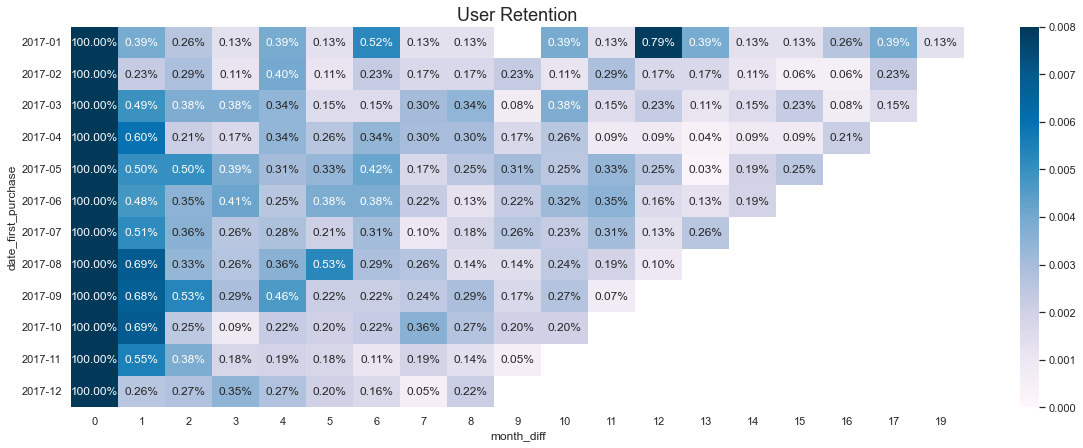

In [328]:
#Построим heatmap для визуализации обещй картины
sns.heatmap(df_retention_final, annot = True,vmin = 0.0, vmax = 0.008, cmap="PuBu", fmt='.2%')
plt.title('User Retention', fontsize=18)

---
Из получившегося графика видно, что пользователи практически не возвращаются за повторными покупками.

---

In [329]:
# Определим когорту с максимальным параметром retention на 3й месяц
df_retention_final[3].idxmax()

Period('2017-06', 'M')

> **Вывод:**
Наибольший параметр **retention** на третий месяц имеет когорта ***2017-06***

---
## 6. RFM- сегментация пользователей для качественной оценки аудитории.
---

---
Последние данные в таблице заказов датируются 17м октября 2018 года, для RFM анализа возьмем данные за последний год. Датой покупки будем считать дату подтверждения платежа.

---

In [330]:
#для анализа нам необходимо собрать данную из таблиц orders, customer и order_items
#из этой таблицы возьмем только небходимые столбцы.
df_rfm = df_order_items.merge(df_orders.merge(df_customers, how='left', on='customer_id'), how='left', on='order_id')
df_rfm.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delta_delivared,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,8 days 00:16:12,871766c5855e863f6eccc05f988b23cb,28013.0,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2 days 07:55:36,eb28e67c4c0b83846050ddfb8a35d051,15775.0,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,13 days 10:40:44,3818d81c6709e39d06b2738a8d3a2474,35661.0,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,5 days 10:27:21,af861d436cfc08b2c2ddefd0ba074622,12952.0,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,15 days 07:17:29,64b576fb70d441e8f1b2d7d446e483c5,13226.0,varzea paulista,SP


In [331]:
#отсортируем заказы исключив из выборки заказы со статусом "canceled" и "unavailable"
#так как мы приняли решение считать датой покупки дату создание заказа, то для удобства переименуем эту колонку
#возьмем только нужные колонки
df_rfm = df_rfm.query('order_status != "canceled" and order_status !="unavailable"')\
                [['order_id','customer_unique_id','product_id','price', 'order_purchase_timestamp']]\
                .rename(columns={'order_purchase_timestamp': 'date_purchase'})

In [332]:
df_rfm.head()

,order_id,customer_unique_id,product_id,price,date_purchase
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,4244733e06e7ecb4970a6e2683c13e61,58.90,2017-09-13 08:59:02
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,e5f2d52b802189ee658865ca93d83a8f,239.90,2017-04-26 10:53:06
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,c777355d18b72b67abbeef9df44fd0fd,199.00,2018-01-14 14:33:31
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,7634da152a4610f1595efa32f14722fc,12.99,2018-08-08 10:00:35
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,ac6c3623068f30de03045865e4e10089,199.90,2017-02-04 13:57:51


---
Датой наблюдения будем считать последнюю известную дату в датафрейме orders

---

In [334]:
#запишем эту дату в отдельную переменную
NOW = df_orders.order_approved_at.max().normalize()
NOW

Timestamp('2018-09-03 00:00:00')

In [335]:
#теперь приведем колонку типа datatime к дате
df_rfm['date_purchase'] = df_rfm['date_purchase'].dt.normalize()

In [336]:
df_rfm.head()

,order_id,customer_unique_id,product_id,price,date_purchase,delta_date
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,4244733e06e7ecb4970a6e2683c13e61,58.90,2017-09-13,354 days 15:00:58
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,e5f2d52b802189ee658865ca93d83a8f,239.90,2017-04-26,494 days 13:06:54
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,c777355d18b72b67abbeef9df44fd0fd,199.00,2018-01-14,231 days 09:26:29
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,7634da152a4610f1595efa32f14722fc,12.99,2018-08-08,25 days 13:59:25
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,ac6c3623068f30de03045865e4e10089,199.90,2017-02-04,575 days 10:02:09


In [337]:
#отфильтруем данные, удалив покупки совершенные больше года назад
#для этого создадим новую колонку и запишем в нее разницу между датой покупки и датой анализа
df_rfm['delta_date'] = NOW - df_rfm['date_purchase']
df_rfm.head()

,order_id,customer_unique_id,product_id,price,date_purchase,delta_date
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,4244733e06e7ecb4970a6e2683c13e61,58.90,2017-09-13,355 days
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,e5f2d52b802189ee658865ca93d83a8f,239.90,2017-04-26,495 days
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,c777355d18b72b67abbeef9df44fd0fd,199.00,2018-01-14,232 days
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,7634da152a4610f1595efa32f14722fc,12.99,2018-08-08,26 days
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,ac6c3623068f30de03045865e4e10089,199.90,2017-02-04,576 days


In [338]:
#теперь отфильтруем строки, в которых покупки были совершены более года назад
df_rfm = df_rfm[df_rfm['delta_date'] <= timedelta(days = 365)]
df_rfm.head()

,order_id,customer_unique_id,product_id,price,date_purchase,delta_date
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,4244733e06e7ecb4970a6e2683c13e61,58.90,2017-09-13,355 days
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,c777355d18b72b67abbeef9df44fd0fd,199.00,2018-01-14,232 days
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,7634da152a4610f1595efa32f14722fc,12.99,2018-08-08,26 days
6,00054e8431b9d7675808bcb819fb4a32,635d9ac1680f03288e72ada3a1035803,8d4f2bb7e93e6710a28f34fa83ee7d28,19.90,2017-12-10,267 days
7,000576fe39319847cbb9d288c5617fa6,fda4476abb6307ab3c415b7e6d026526,557d850972a7d6f792fd18ae1400d9b6,810.00,2018-07-04,61 days


---
Чтобы оценить дату последней покупки(**recency**) сгруппируем данные по уникальному id клиента (**customer_unique_id**), и выберем максимальную дату покупки(**date_purchase**) чтоб оценить частоту покупок (**frequency**) и посчитаем для каждого клиента количество заказов(**order_id**), чтобы посчитать сумму покупок клиента за последний год(**monetary**), при группировке просуммируем колонку цены(**price**)

---

In [340]:
df_rfm_result = df_rfm.groupby('customer_unique_id', as_index=False)\
                        .agg({'delta_date': 'min', 'order_id': 'count', 'price': 'sum'})\
                        .rename(columns={'delta_date': 'recency', 'order_id': 'frequency', 'price': 'monetary'})\
                        .reset_index()
df_rfm_result.head()

,index,customer_unique_id,recency,frequency,monetary
0,0,0000366f3b9a7992bf8c76cfdf3221e2,116 days,1,129.90
1,1,0000b849f77a49e4a4ce2b2a4ca5be3f,119 days,1,18.90
2,2,0000f6ccb0745a6a4b88665a16c9f078,326 days,1,25.99
3,3,0004aac84e0df4da2b147fca70cf8255,293 days,1,180.00
4,4,0004bd2a26a76fe21f786e4fbd80607f,151 days,1,154.00


In [341]:
#для удобства расчетов переведем параметр recency в формат int
df_rfm_result['recency'] = df_rfm_result['recency'].dt.days

In [342]:
#посмотрим описание датафрейма
df_rfm_result.describe()

,index,recency,frequency,monetary
count,73071.000000,73071.000000,73071.000000,73071.000000
mean,36535.000000,176.711007,1.175158,141.249003
std,21093.925097,98.880254,0.615581,211.909230
min,0.000000,0.000000,1.000000,0.850000
25%,18267.500000,93.000000,1.000000,47.900000
50%,36535.000000,176.000000,1.000000,89.900000
75%,54802.500000,264.000000,1.000000,152.895000
max,73070.000000,365.000000,24.000000,13440.000000


---
Чтобы понять как лучше сегментировать клиентов, построем гистограммное распределение для каждого из анализирцемых параметров.

---

<AxesSubplot:xlabel='frequency', ylabel='Count'>

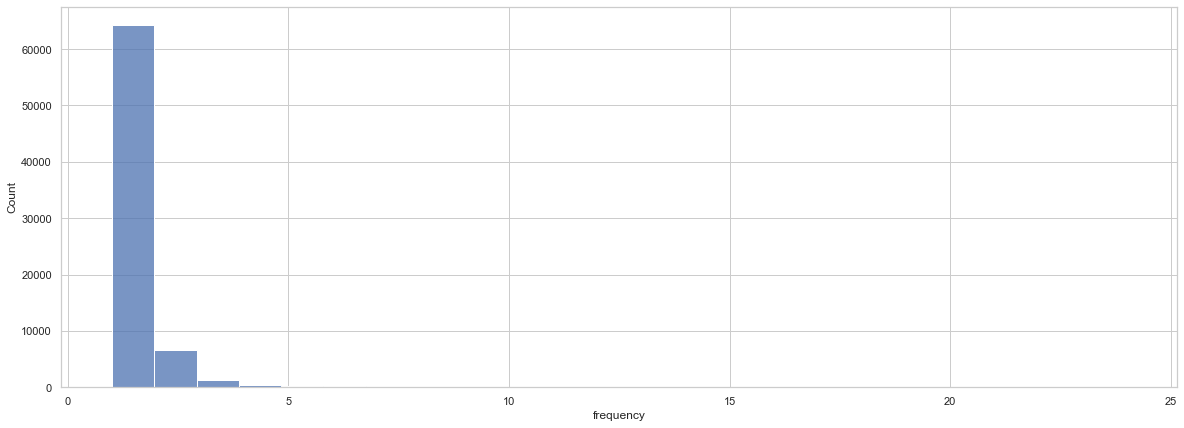

In [345]:
sns.histplot(df_rfm_result.frequency, bins=24)

---
Из построенной гистрограммы видно, что большинство покупок совершались единоразово в течении исследуемого года. попробуем откинуть единоразовые покупки и посмотреть медианное значение, получившихся сегментов.

---

<AxesSubplot:xlabel='frequency', ylabel='Count'>

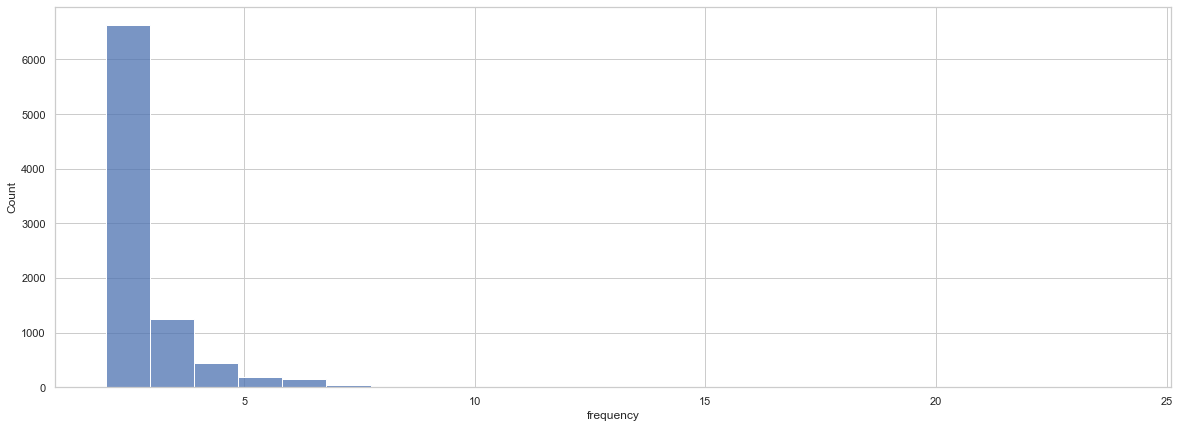

In [346]:
sns.histplot(df_rfm_result.query('frequency > 1').frequency, bins=23)

---
Попробуем в гистограмме убрать клиентов с количеством покупок менее 2х и посмотреть распределение.

---

<AxesSubplot:xlabel='frequency', ylabel='Count'>

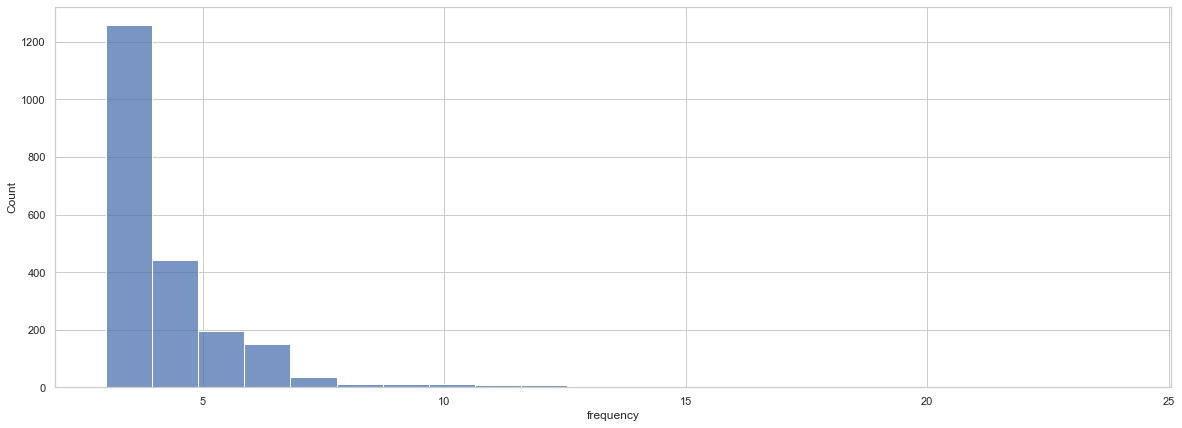

In [86]:
sns.histplot(df_rfm_result.query('frequency > 2').frequency, bins=22)

---
Наблюдаем, что большее количество покупок совершается единоразово. Далее достаточно много клиентов совершаюи дв покупки в течении год следующий сегмент по количество покупок это клиенты с количеством покупок от 3 до 6, и в последний сегмент выделим всех клиентов чье количество покупок больше 6

Таким образом наиболее правильным распределением для нашей выборки будет следущее:\
1 - клиенты совершившие 1 покупку\
2 - клиенты совершившие 2 покупки\
3 - клиенты совершившие от 3х до 6ти покупок\
4 - клиенты совершившие более 6 покупок

---

<AxesSubplot:xlabel='monetary', ylabel='Count'>

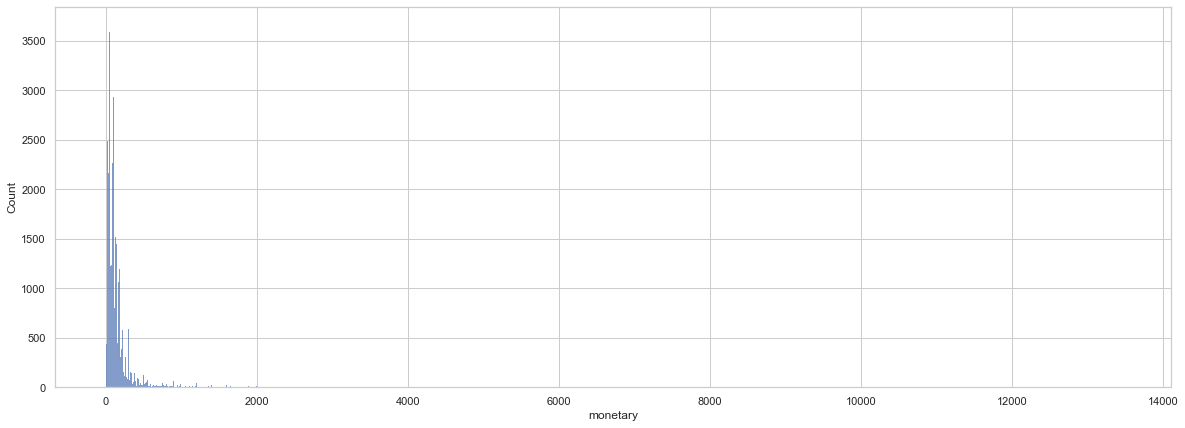

In [347]:
#построим гистограмму для параметра monetary
sns.histplot(df_rfm_result.monetary)

---
На гистограмме видно, что большую часть клиентов суонцентрирована в левой части графика.

Распределение данного параметра построим на основе квантилей. На основе квантилей так же сделаем распределение даты последней покупки.

---

In [348]:
#создадим функции для сегментации каждого параметра
def r_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1

def f_score(x):
    if x <= 1:
        return 1
    elif x <= 2:
        return 2
    elif (x >= 3) and (x <=6):
        return 3
    else:
        return 4
    
def m_score(x):
    if x <= quintiles['monetary'][.2]:
        return 1
    elif x <= quintiles['monetary'][.4]:
        return 2
    elif x <= quintiles['monetary'][.6]:
        return 3
    elif x <= quintiles['monetary'][.8]:
        return 4
    else:
        return 5   

In [349]:
#зададим словать кватнилей, к интресующим нас характеристикам 
quintiles = df_rfm_result[['recency', 'monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'recency': {0.2: 75.0, 0.4: 143.0, 0.6: 208.0, 0.8: 279.0},
 'monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.99, 0.8: 179.8}}

In [350]:
#создадим новые колонки соответствующие рангам наших атрибутов
df_rfm_result['R'] = df_rfm_result['recency'].apply(lambda x: r_score(x))
df_rfm_result['F'] = df_rfm_result['frequency'].apply(lambda x: f_score(x))
df_rfm_result['M'] = df_rfm_result['monetary'].apply(lambda x: m_score(x))
df_rfm_result.head()

,index,customer_unique_id,recency,frequency,monetary,R,F,M
0,0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,4
1,1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1
2,2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1
3,3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,5
4,4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,3,1,4


In [351]:
#создадим третью колонку с сегментацией
df_rfm_result['RFM_Score'] = df_rfm_result['R'].map(str) + df_rfm_result['F'].map(str) + df_rfm_result['M'].map(str)
df_rfm_result.head()

,index,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_Score
0,0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,4,414
1,1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,411
2,2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111
3,3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,5,115
4,4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,3,1,4,314


In [352]:
#оценим какое количество сегментов у нас получилось
df_rfm_result.RFM_Score.nunique()

85

---
Работать с 85 сегментами неудобно, поэтому на основани RFM_score, разделим клиентов на сегменты, используем показатели частоты F и давности покупки R для назначения основных сегментов. 

Champions -	Купили недавно, покупают часто и тратят больше всего\
Loyal Customers - Покупают на регулярной основе.\
Potential Loyalist - Недавние клиенты со средней частотой.\
Recent Customers - Купили совсем недавно, но не часто.\
Promising - Недавно покупали, но не потратили много.\
Customers Needing Attention -	Выше средней недавности, частоты и денежной стоимости. Хотя может и не так давно купил.\
About To Sleep - Ниже средней давности и частоты. Потеряеv их, если не разогреем повторно повторно.\
At Risk	- Покупал часто, но давно. Нужно вернуть их!\
Can’t Lose - Раньше покупали часто, но давно не возвращали.\
Hibernating	- Последняя покупка была давно и мало заказов. Может быть потерян.

---

In [353]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2]3': 'at risk',
    r'[1-2]4': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4]4': 'loyal customers',
    r'4[1,2]': 'promising',
    r'5[1,2]': 'new customers',
    r'[4-5]3': 'potential loyalists',
    r'[4-5]4': 'champions'
}

df_rfm_result['Segment'] = df_rfm_result['R'].map(str) + df_rfm_result['F'].map(str)
df_rfm_result['Segment'] = df_rfm_result['Segment'].replace(segt_map, regex=True)
df_rfm_result.head()

,index,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_Score,Segment
0,0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,4,414,promising
1,1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,411,promising
2,2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111,hibernating
3,3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,5,115,hibernating
4,4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,3,1,4,314,about to sleep


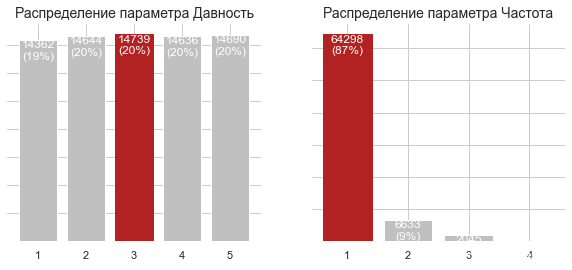

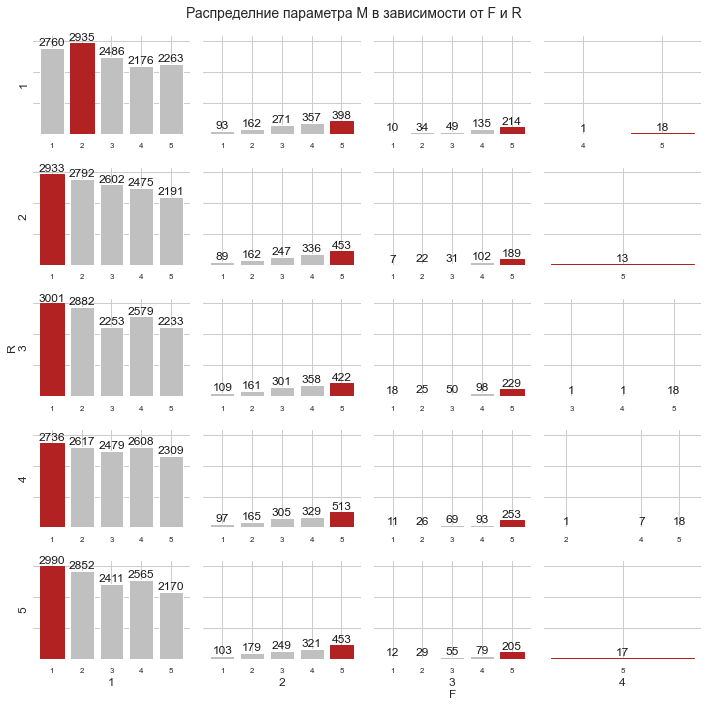

In [354]:
# график распределения клиентов R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Давность', 'F':'Частота'}
    y = df_rfm_result[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Распределение параметра {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# построим график распределения параметр M от RF значений
fig, axes = plt.subplots(nrows=5, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 5)
for r in r_range:
    for f in f_range:
        y = df_rfm_result[(df_rfm_result['R'] == r) & (df_rfm_result['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Распределние параметра M в зависимости от F и R',
             fontsize=14)
plt.tight_layout()
plt.show()

> **Вывод**
>1. Из построенного выше графика видно, что параметр давность(R) рапределен равномерно в разрезе года. В то время как частота имеет явный перекос в сторону клиентов совершивших одну покупку.

>2. Далее на графиках видно, что для клиентов совершивших покупку один раз распределение доходности является равномерным, в то же время если чем чаще совершается покупка, тем более прибылен такой клиент для компании.

>3. Однако количество клиентов совершивших покупку более 6 раз очень мало, и похоже на выбросов



### Теперь визуализируем выручку компании по сформированным сегментам

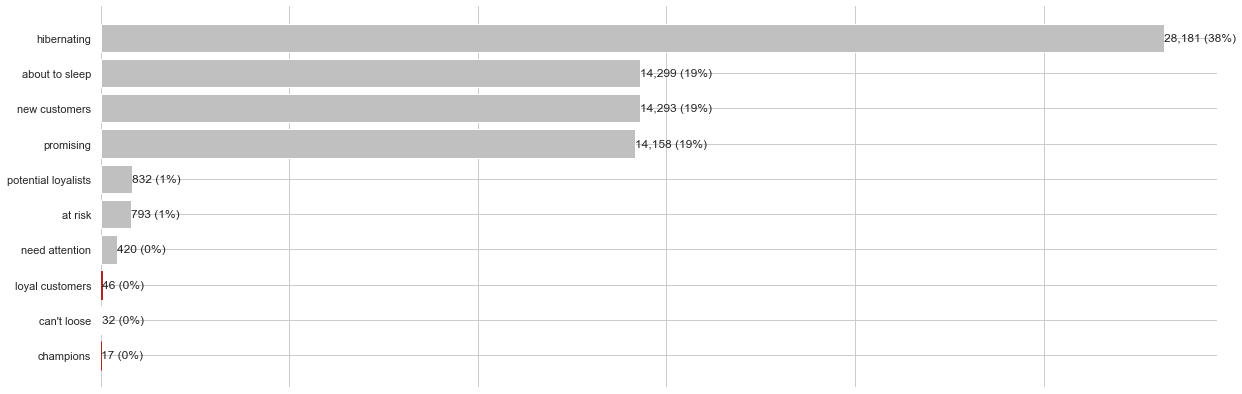

In [355]:
# подсчитаем количество клиентов в каждом сегменте
segments_counts = df_rfm_result['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

> **Вывод:**
Из полученной гистограммы видно что наибольшую выручку компании составляют клиенты которые осуществляют 1-2 покупки. В то время как самые выгодные клиенты не составляют даже 1% от общей суммы выручки. Либо в данной компании продается какой то штучный товар, который требует редкой замены, либо у компании серьезные проблемы с лояльностью клиентов, которые в дальнейшем не хотят повторно приобретать продукцию